In [22]:
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
from census import Census
from pathlib import Path
from api_keys import census_key

In [3]:
county_budget_df = pd.read_csv("../Resources/Budget/Budget_by_County_Merged.csv")
county_budget_df.head()

,State,County/ Congressional District,Veteran Population*,Total Expenditure,Compensation & Pension,Construction,Education & Vocational Rehabilitation/ Employment,Loan Guaranty#,General Operating Expenses,Insurance & Indemnities,Medical Care,Unique Patients**,Year
0,Alaska,ALEUTIANS EAST,179,126,28,0,0,0,0,0,97,9,2010
1,Alaska,ALEUTIANS WEST,387,179,122,0,8,0,0,0,49,24,2010
2,Alaska,ANCHORAGE,31274,190835,81093,13678,19025,0,6550,1487,69002,7718,2010
3,Alaska,BETHEL,1228,731,396,0,37,0,0,0,298,61,2010
4,Alaska,BRISTOL BAY,170,311,190,0,0,0,0,9,112,23,2010


In [4]:
# View entire df as table
county_budget_df.groupby(["State", "County/ Congressional District","Year"]).sum()

Veteran Population*  \
State   County/ Congressional District Year                        
Alabama AUTAUGA                        2010                 5880   
                                       2011                 5846   
                                       2012                 6008   
                                       2013                 6044   
                                       2015                 6063   
...                                                          ...   
Wyoming WESTON                         2010                  709   
                                       2011                  698   
                                       2012                  745   
                                       2013                  742   
                                       2015                  664   

                                             Total Expenditure  \
State   County/ Congressional District Year                      
Alabama AUTAUGA                        2010              30141   
                                       2011              39549   
                                       2012              35671   
                                       2013              43947   
                                       2015              49987   
...                                                        ...   
Wyoming WESTON                         2010               2999   
                                       2011               4046   
                                       2012               4348   
                                       2013               4751   
                                       2015               6921   

                                             Compensation & Pension  \
State   County/ Congressional District Year                           
Alabama AUTAUGA                        2010                   18891   
                                       2011                   25678   
                                       2012                   21903   
                                       2013                   26671   
                                       2015                   32003   
...                                                             ...   
Wyoming WESTON                         2010                    1181   
                                       2011                    1378   
                                       2012                    1223   
                                       2013                    1338   
                                       2015                    1910   

                                             Construction  \
State   County/ Congressional District Year                 
Alabama AUTAUGA                        2010             0   
                                       2011             0   
                                       2012             0   
                                       2013             0   
                                       2015             0   
...                                                   ...   
Wyoming WESTON                         2010             0   
                                       2011             0   
                                       2012             0   
                                       2013             0   
                                       2015             0   

                                             Education & Vocational Rehabilitation/ Employment  \
State   County/ Congressional District Year                                                      
Alabama AUTAUGA                        2010                                               3555   
                                       2011                                               4787   
                                       2012                                               4795   
                                       2013                                               501

In [5]:
# Find most populous locations
high_pops = county_budget_df.groupby(["State", "County/ Congressional District"])["Veteran Population*"].sum().sort_values(ascending=False).head(10)
high_pops = [f"{key[1]}, {key[0]}" for key in high_pops.keys()]
high_pops

['LOS ANGELES, California',
 'MARICOPA, Arizona',
 'SAN DIEGO, California',
 'COOK, Illinois',
 'HARRIS, Texas',
 'CLARK, Nevada',
 'BEXAR, Texas',
 'RIVERSIDE, California',
 'ORANGE, California',
 'KING, Washington']

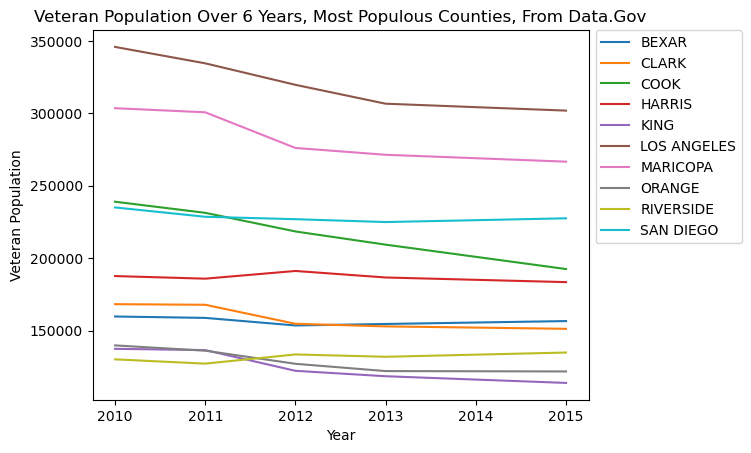

In [47]:
# Graph most populous locations
pivoted = county_budget_df.loc[
    [f"{row[1]['County/ Congressional District']}, {row[1]['State']}" in high_pops for row in county_budget_df.iterrows()],
    ["County/ Congressional District", "Veteran Population*", "Year"]
].pivot(index="Year", columns="County/ Congressional District", values="Veteran Population*")

ax = pivoted.plot(legend=False)
ax.figure.legend(loc="upper right", bbox_to_anchor=(1.15,0.895))
ax.set_ylabel("Veteran Population")
ax.set_title("Veteran Population Over 6 Years, Most Populous Counties, From Data.Gov")
plt.show()

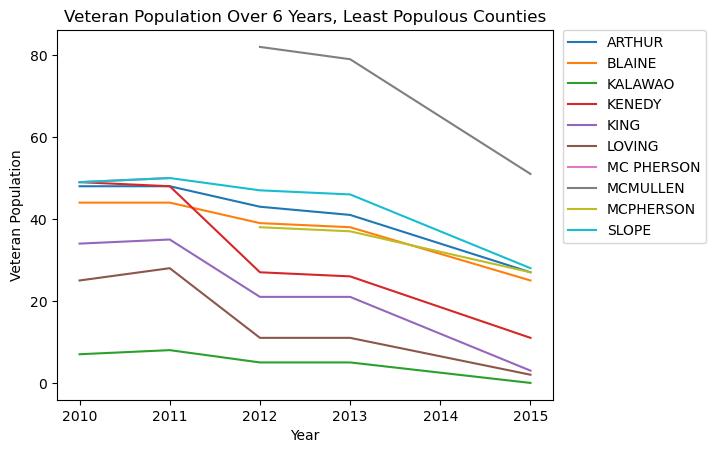

In [7]:
# Find least populous locations
low_pops = county_budget_df.loc[county_budget_df["Veteran Population*"] > 0,:].groupby(["State", "County/ Congressional District"])["Veteran Population*"].sum().sort_values(ascending=True).head(10)
low_pops = [f"{key[1]}, {key[0]}" for key in low_pops.keys()]
low_pops

# Graph least populous locations
pivoted = county_budget_df.loc[
    [f"{row[1]['County/ Congressional District']}, {row[1]['State']}" in low_pops for row in county_budget_df.iterrows()],
    ["County/ Congressional District", "Veteran Population*", "Year"]
].pivot(index="Year", columns="County/ Congressional District", values="Veteran Population*")

ax = pivoted.plot(legend=False)
ax.figure.legend(loc="upper right", bbox_to_anchor=(1.15,0.895))
ax.set_ylabel("Veteran Population")
ax.set_title("Veteran Population Over 6 Years, Least Populous Counties")
plt.show()

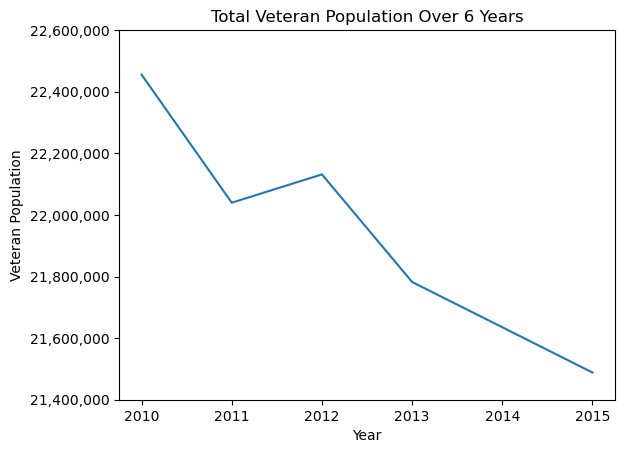

In [8]:
# Find total vet population over years
total_pop = county_budget_df.groupby("Year")["Veteran Population*"].sum()
ax = total_pop.plot()
ax.set_ylabel("Veteran Population")
ax.set_title("Total Veteran Population Over 6 Years")
current_values = ax.get_yticks()
ax.set_yticks(current_values, [f"{x:,.0f}" for x in current_values])
plt.show()

In [41]:
# Find the veteran population from the Census API
year_dfs = []

for year in range(2010, 2016):
    year_data = Census(census_key, year=year).acs5.get(
        ( "NAME", "B21001_002E" ),
        { 'for': 'county:*', 'in': 'state:*' }
    )

    year_df = pd.DataFrame(year_data).rename(
        columns = {
            'county': 'County/ Congressional District',
            'state': 'State',
            'B21001_002E': 'Veteran Population'
        }
    )[[
        "State",
        "County/ Congressional District",
        "Veteran Population"
    ]]

    year_df["Year"] = year
    year_df["County/ Congressional District"] = (year_df["State"] + year_df["County/ Congressional District"]).astype("int")
    year_df["State"] = year_df["State"].astype("int")
    year_df["Veteran Population"] = year_df["Veteran Population"].astype("int")
    
    year_dfs.append(year_df)

census_df = pd.DataFrame(columns=year_dfs[0].columns)

for year_df in year_dfs:
    census_df = census_df.merge(year_df, how='outer')

fips_dict = {}
with Path("../Resources/county_fips_master.csv").open(encoding='cp1252') as f:
    header_fields = f.readline().split(",")
    reader = csv.DictReader(f, fieldnames=header_fields)
    for row in reader:
        county_fips = int(row["fips"])
        fips_dict[county_fips] = row["county_name"].replace(" City and Borough", "").replace(" Census Area", "").replace(" Borough", "").replace(" County", "").replace(" Municipality", "").replace(bytes.fromhex("D0").decode("cp1252"),"n").replace("á","a").replace("í","i").replace("ó","o").replace("ü","u").replace("ñ","n").replace("St.","Saint").upper()
        state_fips = math.floor(county_fips / 1000)
        fips_dict[state_fips] = row["state_name"].title()

census_df = census_df.replace({ "State": fips_dict, "County/ Congressional District": fips_dict })
census_df

,State,County/ Congressional District,Veteran Population,Year
0,Puerto Rico,LAS MARIAS,101,2010
1,Puerto Rico,SAN GERMAN,1426,2010
2,Puerto Rico,COMERIO,404,2010
3,Puerto Rico,CANOVANAS,951,2010
4,Puerto Rico,RINCON,590,2010
...,...,...,...,...
19319,Virginia,CHARLOTTE,977,2015
19320,Texas,BURLESON,1376,2015
19321,Virginia,GREENSVILLE,993,2015
19322,Washington,THURSTON,29109,2015


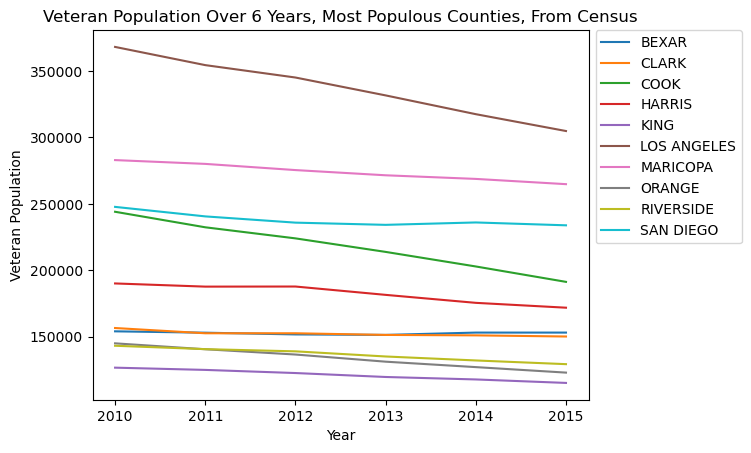

In [62]:
# Find and graph the most populous locations, Census Edition:tm:
high_pops = census_df.groupby(["State", "County/ Congressional District"])["Veteran Population"].sum().sort_values(ascending=False).head(10)
high_pops = [f"{key[1]}, {key[0]}" for key in high_pops.keys()]

pivoted = census_df.loc[
    [f"{row[1]['County/ Congressional District']}, {row[1]['State']}" in high_pops for row in census_df.iterrows()],
    ["County/ Congressional District", "Veteran Population", "Year"]
].pivot(index="Year", columns="County/ Congressional District", values="Veteran Population")

ax = pivoted.plot(legend=False)
ax.figure.legend(loc="upper right", bbox_to_anchor=(1.15,0.895))
ax.set_ylabel("Veteran Population")
ax.set_title("Veteran Population Over 6 Years, Most Populous Counties, From Census")
plt.show()

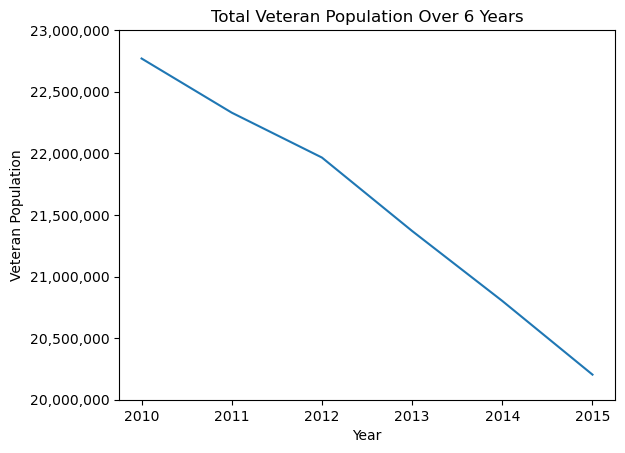

In [61]:
# Find total vet population over years, Census Edition:tm:
total_pop = census_df.groupby("Year")["Veteran Population"].sum()
ax = total_pop.plot()
ax.set_ylabel("Veteran Population")
ax.set_title("Total Veteran Population Over 6 Years")
current_values = ax.get_yticks()
ax.set_yticks(current_values, [f"{x:,.0f}" for x in current_values])
plt.show()

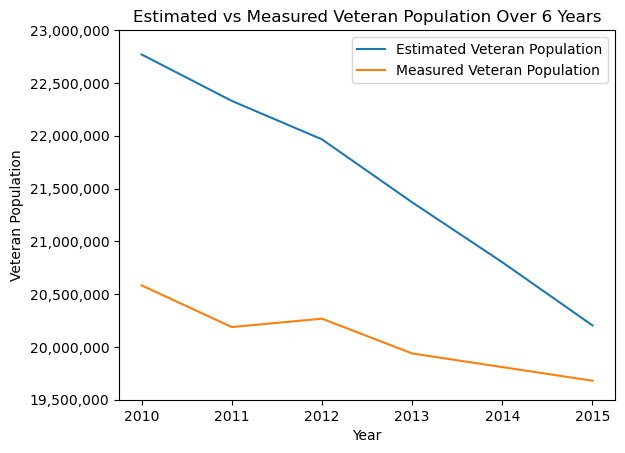

In [65]:
# Here's where it gets messy: it's time to COMBIIIIINE (and cry because of all the NaNs)
merged_df = census_df.merge(county_budget_df, how="left")[["State", "County/ Congressional District", "Veteran Population", "Veteran Population*", "Year"]]
merged_df = merged_df.fillna(0)
merged_df["Veteran Population*"] = merged_df["Veteran Population*"].astype("int")
merged_df = merged_df.rename({
    "Veteran Population": "Estimated Veteran Population",
    "Veteran Population*": "Measured Veteran Population"
}, axis=1)

# Make measured data not dip down to 0 in 2014, for lack of data sets for that year
total_pop_df = merged_df.groupby("Year").sum(numeric_only=True)
total_pop_df["Measured Veteran Population"][2014] = (total_pop_df["Measured Veteran Population"][2013] + total_pop_df["Measured Veteran Population"][2015]) / 2

ax = total_pop_df.plot()
ax.set_ylabel("Veteran Population")
ax.set_title("Estimated vs Measured Veteran Population Over 6 Years")
current_values = ax.get_yticks()
ax.set_yticks(current_values, [f"{x:,.0f}" for x in current_values])
plt.show()